<a href="https://colab.research.google.com/github/RocioLiu/AI-for-Trading/blob/main/Simple_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Simple RNN**
In this notebook, we're going to train a simple RNN to do **time-series prediction**. Given some set of input data, it should be able to generate a prediction for the next time step!
![](https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/231590b713d54096cbd4cdf8944750517faa13d2/recurrent-neural-networks/time-series/assets/time_prediction.png)

* First, we'll create our data
* Then, define an RNN in PyTorch
* Finally, we'll train our network and see how it performs

### **Import resources and create data**

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

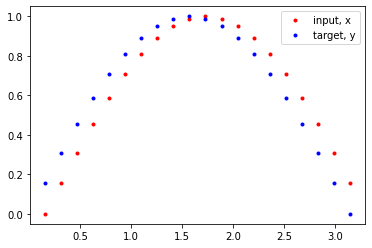

In [2]:
# how many time steps/data pts are in one batch of data
seq_length = 20

# generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size(num of features) dimension

x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [3]:
print('time_steps size:', time_steps.shape)
print('data size:', data.shape)

time_steps size: (21,)
data size: (21, 1)


## **Define the RNN**
Next, we define an RNN in PyTorch. We'll use nn.RNN to create an RNN layer, then we'll add a last, fully-connected layer to get the output size that we want. An RNN takes in a number of parameters:

* **input_size** - the size of the input
* **hidden_dim** - the number of features in the RNN output and in the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
* **batch_first** - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)
Take a look at the [RNN documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) to read more about recurrent layers.

After creating an RNN instance, the input of the RNN model should be:
* **input** : tensor of shape `(L, N, H_in)` when `batch_first=False` or `(N, L, H_in)` when `batch_first=True` containing the features of the input sequence. 
* **h_0** : tensor of shape `(D * num_layers, N, H_out)` containing the initial hidden state for each element in the batch. Defaults to zeros if not provided.

The output:
* **output** : tensor of shape `(L, N, D * H_out)` when `batch_first=False` or `(N, L, D * H_out)` when `batch_first=True` containing the output features (`h_t`) from the last layer of the RNN, for each `t`.

* **h_n** : tensor of shape (D * num_layers, N, H_out) containing the final hidden state for each element in the batch.

Where 
* `N` = batch size
* `L` = sequence length
* `D` = 2 if bidirectional=True otherwise 1
* `H_in` = input_size
* `H_out` = hidden_size (i.e. hidden_dim)

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)

        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden) # This produce the RNN output and a new hidden state
        # shape output to be (batch_size*seq_length, hidden_dim)
        # This is a flattening step where I'm preparing the output to be fed into a fully-connected layer
        r_out = r_out.view(-1, self.hidden_dim) 

        # get final output
        output = self.fc(r_out)

        return output, hidden

### **Check the input and output dimensions**
As a check that your model is working as expected, test out how it responds to input data.

In [5]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# generate evenly spaced, test data pts
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size:', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size: torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


The output size is a 2D tensor. This is because in the forward function of our model definition smooshed the batch size and seqence length into one parameter (batch_size * seq_length, hidden_dim) = (20, 1).

The final hidden state size is (n_layers, batch_size, H_out) = (2, 1, 10)

## **Training the RNN**
Next, we'll instantiate an RNN with some specified hyperparameters. Then train it over a series of steps, and see how it performs.

